# 1 Data and libraries

In [1]:
# Base
import numpy as np
import pandas as pd
from tqdm import tqdm

# Nice plots
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import shap

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


## 1.1 Presentation

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

display(train)

train.info()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0
...,...,...,...,...,...,...,...,...,...,...,...,...
381104,381105,Male,74,1,26.0,1,1-2 Year,No,30170.0,26.0,88,0
381105,381106,Male,30,1,37.0,1,< 1 Year,No,40016.0,152.0,131,0
381106,381107,Male,21,1,30.0,1,< 1 Year,No,35118.0,160.0,161,0
381107,381108,Female,68,1,14.0,0,> 2 Years,Yes,44617.0,124.0,74,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 381109 entries, 0 to 381108
Data columns (total 12 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    381109 non-null  int64  
 1   Gender                381109 non-null  object 
 2   Age                   381109 non-null  int64  
 3   Driving_License       381109 non-null  int64  
 4   Region_Code           381109 non-null  float64
 5   Previously_Insured    381109 non-null  int64  
 6   Vehicle_Age           381109 non-null  object 
 7   Vehicle_Damage        381109 non-null  object 
 8   Annual_Premium        381109 non-null  float64
 9   Policy_Sales_Channel  381109 non-null  float64
 10  Vintage               381109 non-null  int64  
 11  Response              381109 non-null  int64  
dtypes: float64(3), int64(6), object(3)
memory usage: 34.9+ MB


Our goal will be to predict the target `Response`.

## 1.2 Exploratory analysis

First, let us have a look at the correlations between our regressors.

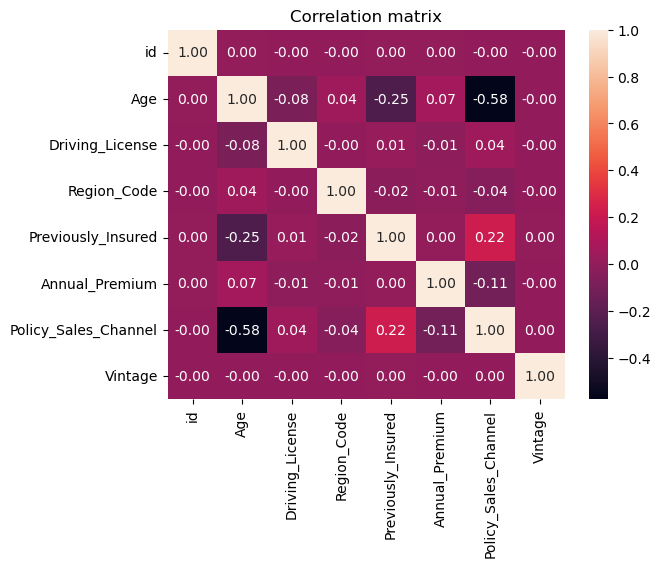

In [3]:
correlations = train.drop(['Response'], axis=1).corr(numeric_only=True)
sns.heatmap(correlations, annot=True, fmt='.2f')
plt.title("Correlation matrix")
plt.show()

What can we say about the correlations of the regressors with the targets?

In [4]:
train.corr(numeric_only=True).iloc[:-1, -1]

id                     -0.001368
Age                     0.111147
Driving_License         0.010155
Region_Code             0.010570
Previously_Insured     -0.341170
Annual_Premium          0.022575
Policy_Sales_Channel   -0.139042
Vintage                -0.001050
Name: Response, dtype: float64

What can we say about the target in itself?

In [5]:
counts = train['Response'].value_counts()
print(f'There are {counts[1]} responses (Response = 1) for a total training set of size {counts.sum()}. This corresponds to a ratio of {counts[1]/counts.sum()}.')
print(f'This means that a dumb classifier would at least show an accuracy of at least {counts[0]/counts.sum()}')

There are 46710 responses (Response = 1) for a total training set of size 381109. This corresponds to a ratio of 0.12256336113815208.
This means that a dumb classifier would at least show an accuracy of at least 0.877436638861848


## 1.3 Features engineering

In [6]:
train = train.drop(['id'], axis=1)

train['Gender'] = train['Gender'].map({'Male': 1, 'Female': 0})
train['Vehicle_Damage'] = train['Vehicle_Damage'].map({'Yes': 1, 'No': 0})
train['Vehicle_Age'] = train['Vehicle_Age'].map({'> 2 Years': 2, '1-2 Year': 1, '< 1 Year': 0})


train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 381109 entries, 0 to 381108
Data columns (total 11 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Gender                381109 non-null  int64  
 1   Age                   381109 non-null  int64  
 2   Driving_License       381109 non-null  int64  
 3   Region_Code           381109 non-null  float64
 4   Previously_Insured    381109 non-null  int64  
 5   Vehicle_Age           381109 non-null  int64  
 6   Vehicle_Damage        381109 non-null  int64  
 7   Annual_Premium        381109 non-null  float64
 8   Policy_Sales_Channel  381109 non-null  float64
 9   Vintage               381109 non-null  int64  
 10  Response              381109 non-null  int64  
dtypes: float64(3), int64(8)
memory usage: 32.0 MB


In [7]:
def remove_outliers(df, col_name):
    q25 = df[col_name].quantile(0.25)
    q75 = df[col_name].quantile(0.75)
    
    cut_off = 1.5 * (q75 - q25)
    lower, upper = max(0, q25 - cut_off), q75 + cut_off
    
    df.loc[df[col_name] > upper, col_name] = upper
    df.loc[df[col_name] < lower, col_name] = lower
    
    return df[col_name]

train['Annual_Premium'] = remove_outliers(train, 'Annual_Premium')

# 2 Model selection 

## 2.1 Random forest / XGBoost

In [8]:
def print_metrics(y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    pre = precision_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    print(f'Accuracy: {acc}\nRecall: {rec}\nPrecision: {pre}\nF1-score: {f1}')

In [9]:
X = train.drop(['Response'], axis=1)
y = train['Response']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

sampler = RandomUnderSampler()
X_train_resampled, y_train_resampled = sampler.fit_resample(X_train_scaled, y_train)

In [10]:
forest = RandomForestClassifier(n_estimators=100, max_depth=3)
forest.fit(X_train_resampled, y_train_resampled)
y_forest = forest.predict(X_test_scaled)
confusion_matrix_forest = confusion_matrix(y_test, y_forest)
tn_forest, fp_forest, fn_forest, tp_forest = confusion_matrix_forest.ravel()
print("--- Metrics for the Random Forest ---")
print(f'tn = {tn_forest}, fp = {fp_forest}, fn = {fn_forest}, tp = {tp_forest}')
print_metrics(y_test, y_forest)

--- Metrics for the Random Forest ---
tn = 44936, fp = 21994, fn = 763, tp = 8529
Accuracy: 0.7014379050667786
Recall: 0.9178863538527766
Precision: 0.27942862759230747
F1-score: 0.428431495667462


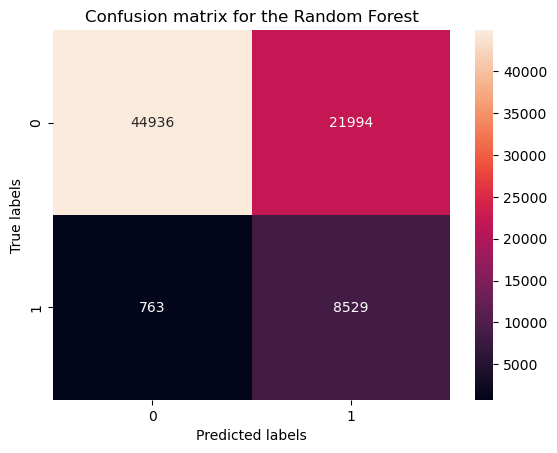

In [11]:
ax= plt.subplot()
sns.heatmap(confusion_matrix_forest, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion matrix for the Random Forest'); 
# ax.xaxis.set_ticklabels(['business', 'health']); ax.yaxis.set_ticklabels(['health', 'business']);

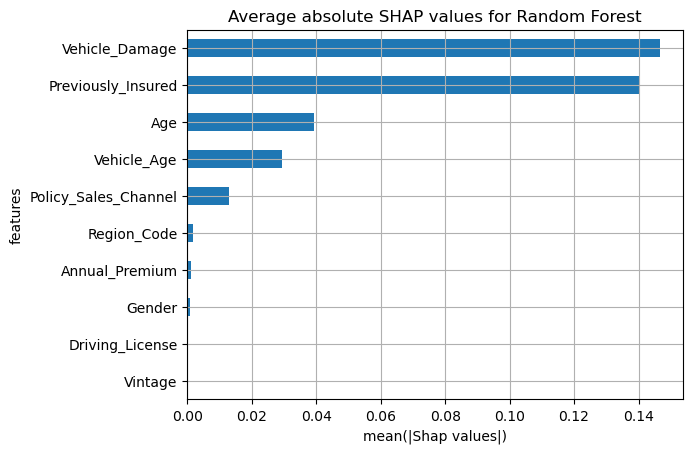

In [12]:
explainer = shap.TreeExplainer(forest)
shap_values = explainer.shap_values(X_test_scaled)
average_shap_values = pd.Series(np.abs(shap_values[0]).mean(axis=0), index=X.columns)
average_shap_values.sort_values().plot(kind='barh')
plt.grid()
plt.xlabel('mean(|Shap values|)')
plt.ylabel('features')
plt.title('Average absolute SHAP values for Random Forest')
plt.show()

In [13]:
booster = XGBClassifier()
booster.fit(X_train_resampled, y_train_resampled)
y_booster = booster.predict(X_test_scaled)
confusion_matrix_booster = confusion_matrix(y_test, y_booster)
tn_booster, fp_booster, fn_booster, tp_booster = confusion_matrix_booster.ravel()
print("--- Metrics for the XGBoost ---")
print(f'tn = {tn_booster}, fp = {fp_booster}, fn = {fn_booster}, tp = {tp_booster}')
print_metrics(y_test, y_booster)

--- Metrics for the XGBoost ---
tn = 45570, fp = 21360, fn = 771, tp = 8521
Accuracy: 0.7096507569992916
Recall: 0.9170253981919931
Precision: 0.2851644857936481
F1-score: 0.4350445459883082


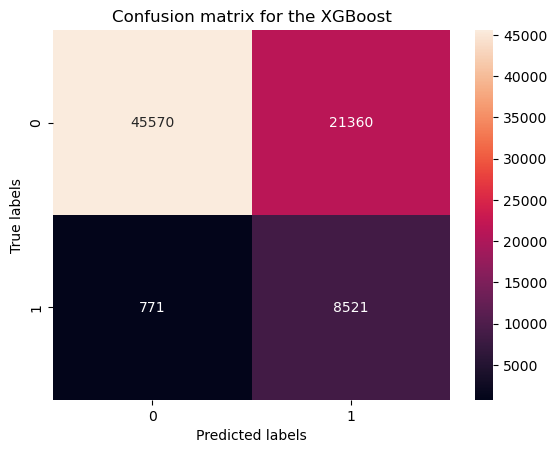

In [14]:
ax= plt.subplot()
sns.heatmap(confusion_matrix_booster, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion matrix for the XGBoost'); 
# ax.xaxis.set_ticklabels(['business', 'health']); ax.yaxis.set_ticklabels(['health', 'business']);

[09:53:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


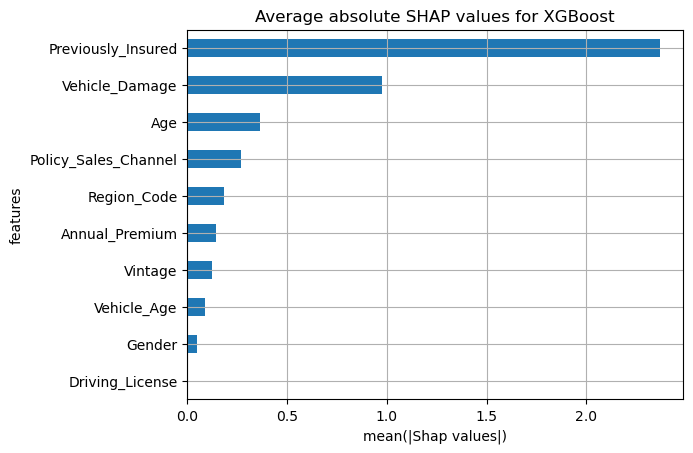

In [15]:
explainer = shap.TreeExplainer(booster)
shap_values = explainer.shap_values(X_test_scaled)

average_shap_values = pd.Series(np.abs(shap_values).mean(axis=0), index=X.columns)
average_shap_values.sort_values().plot(kind='barh')
plt.grid()
plt.xlabel('mean(|Shap values|)')
plt.ylabel('features')
plt.title('Average absolute SHAP values for XGBoost')
plt.show()

## Deep Learning

In [16]:
# Training consists of gradient steps over mini batch of data
def train(model, trainloader, criterion, optimizer, epoch, num_epochs):
    # We enter train mode. This is useless for the linear model
    # but is important for layers such as dropout, batchnorm, ...
    model.train()

    loop = tqdm(trainloader)
#     loop.set_description(f'Training Epoch [{epoch + 1}/{num_epochs}]')

    # We iterate over the mini batches of our data
    for inputs, targets in loop:

        optimizer.zero_grad() # Erase any previously stored gradient
        outputs = model(inputs) # Forwards stage (prediction with current weights)
        targets = targets.view(-1, 1) # Reshape targets to match the output size
        loss = criterion(outputs, targets) # loss evaluation
        loss.backward() # Back propagation (evaluate gradients)

        # Making gradient step on the batch (this function takes care of the gradient step for us)
        optimizer.step()

def validation(model, valloader, criterion):
    # Do not compute gradient, since we do not need it for validation step
    with torch.no_grad():
        
        model.eval() # We enter evaluation mode.

        total, correct = 0, 0 # Keep track of currently used samples
        running_loss = 0.0 # Accumulated loss without averaging

        loop = tqdm(valloader) # This is for the progress bar
#         loop.set_description('Validation in progress')

        # We again iterate over the batches of validation data. batch_size does not play any role here
        for inputs, targets in loop:
            outputs = model(inputs) # Run samples through our net
            total += inputs.shape[0] # Total number of used samples
            predicted = torch.round(outputs)
            targets = targets.view(-1, 1)
            correct += (predicted == targets).sum().item()
            
            # Multiply loss by the batch size to erase averagind on the batch
            batch_loss = criterion(outputs, targets).item()
            running_loss += batch_loss * inputs.shape[0]
            
#             loop.set_postfix(val_loss=(running_loss / total), val_acc=(correct / total)) # Set nice progress message
        return running_loss / total, correct / total

In [17]:
class FeedForwardNet(nn.Module):
    def __init__(self, input_size, hidden_sizes, dropout_prob=0.5):
        super(FeedForwardNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_sizes[0])
        self.relu = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout_prob)  # Dropout layer after first hidden layer
        self.fc2 = nn.Linear(hidden_sizes[0], hidden_sizes[1])
        self.dropout2 = nn.Dropout(dropout_prob)  # Dropout layer after second hidden layer
        self.fc3 = nn.Linear(hidden_sizes[1], 1)
        self.sigmoid = nn.Sigmoid()  # Use sigmoid activation for binary classification

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.dropout1(out)  # Applying dropout after first hidden layer
        out = self.fc2(out)
        out = self.relu(out)
        out = self.dropout2(out)  # Applying dropout after second hidden layer
        out = self.fc3(out)
        out = self.sigmoid(out)
        return out

In [18]:
# Convert data to PyTorch DataLoader
X_train_tensor = torch.tensor(X_train_resampled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_resampled, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataset = TensorDataset(X_test_tensor, y_test_tensor)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)  # No need to shuffle for validation

In [19]:
# Set training parameters
num_epochs = 5 # num_epochs indicates the number of passes over the data
criterion = nn.BCELoss()
learning_rate = 0.001

In [20]:
# # TRES LONG A TOURNER, NE PAS RUN CETTE CELLULE EN PREMIER LIEU
# # ELLE SERT A OPTIMISER LES PARAMETRES DU RESEAU DE NEURONES




# # Settings for the training of FFN
# input_size = X_train_tensor.shape[1]
# hidden_sizes = [64, 32]
# dropout_prob = 0.8

# results = np.zeros((40, 11))
# k = 0
# for hidden_size_1 in [64, 32]:
#     for hidden_size_2 in [32, 16]:
#         for dropout_prob in np.logspace(-3, -1, 10):
#             hidden_sizes = [hidden_size_1, hidden_size_2]
#             ffn_model = FeedForwardNet(input_size, hidden_sizes, dropout_prob)
#             ffn_optimizer = optim.Adam(ffn_model.parameters(), lr=learning_rate)
#             print(f"\n[hidden_sizes = {hidden_sizes}][dropout_prob = {dropout_prob}]")
#             for epoch in range(num_epochs):
#                 # makes one pass over the train data and updates weights
#                 train(ffn_model, train_loader, criterion, ffn_optimizer, epoch, num_epochs)

#                 # makes one pass over validation data and provides validation statistics
#                 val_loss, val_acc = validation(ffn_model, val_loader, criterion)
                
#             ffn_model.eval()
#             with torch.no_grad():
#                 y_ffn = ffn_model(X_test_tensor)

#             tn, fp, fn, tp = confusion_matrix(y_test, y_ffn.round()).ravel()
#             acc = accuracy_score(y_test, y_ffn.round())
#             rec = recall_score(y_test, y_ffn.round())
#             pre = precision_score(y_test, y_ffn.round())
#             f1 = f1_score(y_test, y_ffn.round())
            
#             results[k] = hidden_size_1, hidden_size_2, dropout_prob, tn, fp, fn, tp, acc, rec, pre, f1
#             print_metrics(y_test, y_ffn.round())
            
#             k += 1
# results = pd.DataFrame(results, columns=['hidden_size_1', 'hidden_size_2', 'dropout_prob', 'tn', 'fp', 'fn', 'tp', 'acc', 'rec', 'pre', 'f1']).sort_values(by='f1', ascending=False)

In [21]:
# best_params = results.iloc[0]
# input_size = X_train_tensor.shape[1]
# hidden_sizes = [best_params['hidden_size_1'].astype(int), best_params['hidden_size_2'].astype(int)]
# dropout_prob = best_params['dropout_prob']

input_size = X_train_tensor.shape[1]
hidden_sizes = [32, 32]
dropout_prob = 0.1
ffn_model = FeedForwardNet(input_size, hidden_sizes, dropout_prob)
ffn_optimizer = optim.Adam(ffn_model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    # makes one pass over the train data and updates weights
    train(ffn_model, train_loader, criterion, ffn_optimizer, epoch, num_epochs)

    # makes one pass over validation data and provides validation statistics
    val_loss, val_acc = validation(ffn_model, val_loader, criterion)

ffn_model.eval()
with torch.no_grad():
    y_ffn = ffn_model(X_test_tensor)

confusion_matrix_ffn = confusion_matrix(y_test, y_ffn.round())
tn, fp, fn, tp = confusion_matrix_ffn.ravel()
acc = accuracy_score(y_test, y_ffn.round())
rec = recall_score(y_test, y_ffn.round())
pre = precision_score(y_test, y_ffn.round())
f1 = f1_score(y_test, y_ffn.round())


print("--- Metrics for the Neural Network ---")
print(f'tn = {tn}, fp = {fp}, fn = {fn}, tp = {tp}')
print_metrics(y_test, y_ffn.round())

100%|████████████████████████████████████████████████████████████████████████████| 4764/4764 [00:01<00:00, 3272.98it/s]


--- Metrics for the Neural Network ---
tn = 44871, fp = 22059, fn = 711, tp = 8581
Accuracy: 0.7012673506336753
Recall: 0.9234825656478691
Precision: 0.28005874673629244
F1-score: 0.4297806270660123


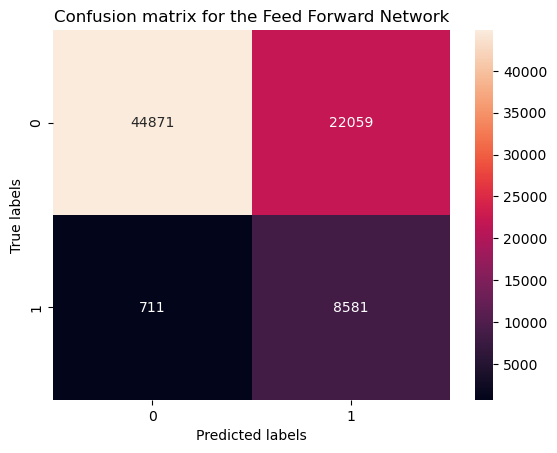

In [22]:
ax= plt.subplot()
sns.heatmap(confusion_matrix_ffn, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion matrix for the Feed Forward Network'); 
# ax.xaxis.set_ticklabels(['business', 'health']); ax.yaxis.set_ticklabels(['health', 'business']);